# Persistence Images in Classification

This notebook shows how you can use persistent homology and persistence images to classify datasets.  We construct datasets from two classes, one just noise and the other noise with a big circle in the middle. We then compute persistence diagrams with [Ripser.py](https://github.com/scikit-tda/ripser.py) and convert them to persistence images with [PersIm](https://github.com/scikit-tda/persim). Using these persistence images, we build a Logistic Regression model using a LASSO penatly to classify whether the dataset has a circle or not.  We find, using only default values, classification has a mean accuracy greater than 90.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm, metrics
import matplotlib.pyplot as plt
import sklearn_tda as tda

from ripser import Rips
from persim import PersImage

Gudhi not found--GraphInducedComplex not available


## Construct data

Generate N datasets that are just noise and N that are noise with a circle. 

In [3]:
N = 50
N_per_class = int(N / 2)
N_in_class = 40

def noise(N, scale):
    return scale * np.random.random((N, 2))

def circle(N, scale, offset):
    return offset + scale * datasets.make_circles(n_samples=N, factor=0.4, noise=0.05)[0]
    
just_noise = [noise(N_in_class, 15) for _ in range(N_per_class)]

half = int(N_in_class / 2)
with_circle = [np.concatenate((circle(half, 50, 70), noise(half, 15)))
               for _ in range(N_per_class)]

datas = []
datas.extend(just_noise)
datas.extend(with_circle)

# Define labels
labels = np.zeros(N)
labels[N_per_class:] = 1

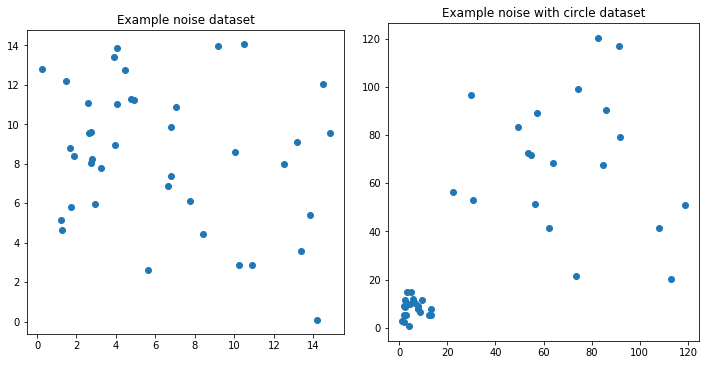

In [4]:
# Visualize the data
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10,5)

xs, ys = just_noise[0][:,0], just_noise[0][:,1]
axs[0].scatter(xs, ys)
axs[0].set_title("Example noise dataset")
axs[0].set_aspect('equal', 'box')

xs_, ys_ = with_circle[1][:,0], with_circle[0][:,1]
axs[1].scatter(xs_, ys_)
axs[1].set_title("Example noise with circle dataset")
axs[1].set_aspect('equal', 'box')

fig.tight_layout()

## Compute homology of each dataset

Generate the persistence diagram of $H_1$ for each of the datasets generated above.

In [5]:
%%time
rips = Rips(maxdim = 1, coeff=2)
diagrams = [rips.fit_transform(data) for data in datas]
diagrams_h1 = [rips.fit_transform(data)[1] for data in datas]
diagrams_h0 = [rips.fit_transform(data)[0] for data in datas]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
CPU times: user 187 ms, sys: 3.56 ms, total: 191 ms
Wall time: 190 ms


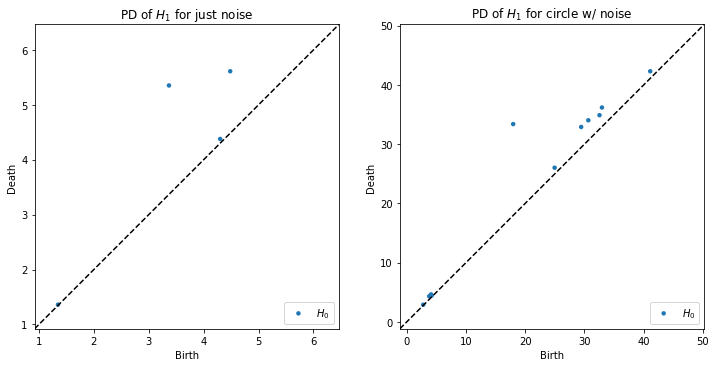

In [6]:
plt.figure(figsize=(12,6))
plt.subplot(121)

rips.plot(diagrams_h1[0], show=False)
plt.title("PD of $H_1$ for just noise")

plt.subplot(122)
rips.plot(diagrams_h1[-1], show=False)
plt.title("PD of $H_1$ for circle w/ noise")

plt.show()

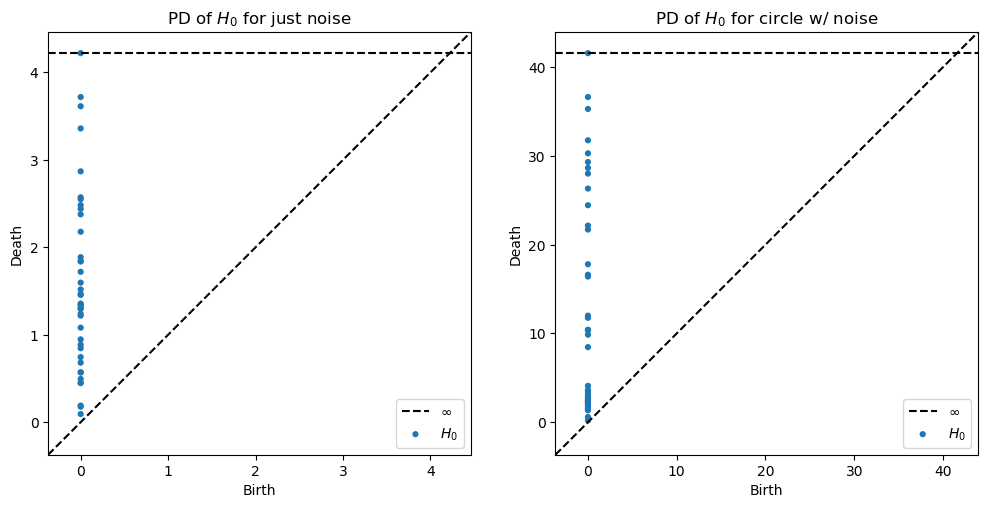

In [7]:
plt.figure(figsize=(12,6))
plt.subplot(121)

rips.plot(diagrams_h0[0], show=False)
plt.title("PD of $H_0$ for just noise")

plt.subplot(122)
rips.plot(diagrams_h0[-1], show=False)
plt.title("PD of $H_0$ for circle w/ noise")

plt.show()

## Compute persistence images

Convert each persistence diagram into a persistence image. Flatten each image into a vector format

In [8]:
X_train, X_test, y_train, y_test = train_test_split(diagrams_h0, labels, test_size=0.20, random_state=42)
# X_train = [[x] for x in X_train]
# X_test = [[x] for x in X_test]

In [9]:
print(len(diagrams_h1))
print(len(X_train))
print(len(X_test))

50
40
10


In [10]:
PSS = tda.PersistenceScaleSpaceKernel(bandwidth=1.)

In [12]:
PSS.fit(X_train)

/home/apaar/anaconda3/envs/tda/lib/python3.6/site-packages/sklearn_tda/kernel_methods.py:75: RuntimeWarning: invalid value encountered in matmul
  op_D = np.matmul(self.diagrams_[i], np.array([[0.,1.], [1.,0.]]))


PersistenceScaleSpaceKernel(bandwidth=None, kernel_approx=None)

In [13]:
PSS.fit(X_train)
train_kernel = np.zeros([len(X_train)]*2)
for i in range(len(X_train)):
    train_kernel[i,:] = PSS.transform([X_train[i]])

/home/apaar/anaconda3/envs/tda/lib/python3.6/site-packages/sklearn_tda/kernel_methods.py:86: RuntimeWarning: invalid value encountered in matmul
  op_X = np.matmul(Xp[i], np.array([[0.,1.], [1.,0.]]))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [30]:
PSS.transform(X_train[:10])

False


/home/apaar/anaconda3/envs/tda/lib/python3.6/site-packages/sklearn_tda/kernel_methods.py:86: RuntimeWarning: invalid value encountered in matmul
  op_X = np.matmul(Xp[i], np.array([[0.,1.], [1.,0.]]))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [32]:
classifier = svm.SVC(gamma=0.001, kernel="precomputed")
#fit to the trainin data
PSS= tda.PersistenceScaleSpaceKernel(bandwidth=400.)

a= PSS.fit(X_train)
b= PSS.transform(X_test)

#PSS = tda.PersistenceScaleSpaceKernel(bandwidth=1.)
#X = PSS.fit(diags)
#Y = PSS.transform(diags2)
#print("PSS kernel is " + str(Y[0][0]))

#clf = svm.SVC(kernel='precomputed')
# linear kernel computation
#gram = np.dot(X, X.T)
#clf.fit(gram, y) 

TypeError: ufunc 'matmul' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [18]:
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, y_pred)))

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
              precision    recall  f1-score   support

         0.0       1.00      0.57      0.73        40
         1.0       0.70      1.00      0.82        40

   micro avg       0.79      0.79      0.79        80
   macro avg       0.85      0.79      0.78        80
weighted avg       0.85      0.79      0.78        80




In [19]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))

Confusion matrix:
[[23 17]
 [ 0 40]]


In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

In [11]:
lr.score(X_test, y_test)

0.9875

So these are perfectly descriminative? Seems almost too good to be true. Let's see what features are important.

## Inverse analysis on LASSO 

Visualizing the regression coefficients as a persistence image shows us which features of the images are most important for classification.

In [ ]:
inverse_image = np.copy(lr.coef_).reshape((20,20))
pim.show(inverse_image)

# Slightly less trivial: classify shapes

In [ ]:
import os
pd_data = {}
data_dir = '../data/ToyData_PD_TextFiles/'

for f in os.listdir(data_dir):
    pd_data[f] = np.genfromtxt(data_dir + f);
    

In [ ]:
dim = 1
dgms = []
labels = []
for f in pd_data:
    args = f.split('_');
    if args[-1][0] == str(dim):
        dgms.append(pd_data[f])
        labels.append(args[2]);
    

In [ ]:
imgs = pim.transform(dgms)

In [ ]:
imgs_array = np.array([img.flatten() for img in imgs])
X_train, X_test, y_train, y_test = train_test_split(imgs_array, labels, test_size=0.40, random_state=42)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

In [ ]:
lr.score(X_test, y_test), set(labels)